# M1. Actividad 

### Paola Adriana Millares Forno - A01705674
### 19/11/2021

Para esta actividad se debe generar una habitación de MxN, en la cual existirán distintas celdas que se encuentren sucias. El agente que deberemos modelar es una aspiradora que se dedica a limpiar las celdas. 

Las celdas sucias se deben iniciar de forma aleatoria y todas las aspiradoras deben empezar en la posición (1,1). 

La aspiradora deberá recorrer las celdas, en caso de estar sucia, la limpiara, si esta está limpia se moverá de celda. 

Como recopilación final se deben conseguir los siguientes datos:
    Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).
    Porcentaje de celdas limpias después del término de la simulación.
    Número de movimientos realizados por todos los agentes.

### Código  

Para comenzar con el código, lo primero que debemos hacer es definir las librerias. Utilizaremos mesa para modelar los agentes, matplotlib para poder graficar y animar la interacción del agente con su entorno, el resto de las librerias nos sirven para manejo del tiempo o son librerias matemáticas. 

In [105]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd

import time
import datetime

Declaramos la primera clase que modelará a nuestra aspiradora, esta sera la clase Robot. Este contara con: 
    unique_id: es un identificador unico de cada agente
    model: es el comportamiento que sigue el agente 
    ancho: la medida de la habitación en el eje x 
    alto: la medida de la habitación en el eje y
    sucio: El porcentaje de celdas que debe limpiar 
    direccion: lugar en el que se encuentra el agente, siempre empieza en (1,1)
    velocidad = ayuda a generar el movimiento del agente 
    movimientos: el numero de movimientos que realizó el agente
    direcciones: posibles coordenadas a las que se puede mover el agente
    visitados: número de celdas limpias.
    
Se declaran los métodos para realizar el movimiento de la aspiradora en las distintas direcciones norte, sur, este, oeste, noreste, noroeste, sureste, suroeste, con sus respectivas coordenadas de movimiento.


In [106]:
class Robot(Agent):
    def __init__(self, unique_id, model, ancho, alto, sucio):
        super().__init__(unique_id, model)

        # Declaración de variables
        self.ancho = ancho
        self.alto = alto
        self.sucio = sucio
        self.posicion = np.array((1,1), dtype = int)
        vel_x = np.random.randint(2)
        vel_y = np.random.randint(2)
        self.velocidad = np.array((vel_x, vel_y), dtype = int)
        self.movimientos = 0
        self.visitados = 0
        self.direcciones = ["norte", "sur", "este", "oeste", "noreste", "noroeste", "sudeste", "sudoeste"]
        
        
    def step(self):
        self.bordes()
        self.mover()
        
        if self.limpia() == True:
            self.posicion += self.velocidad
            self.movimientos += 1
        
        
    def mover(self):
        direccion = np.random.choice(self.direcciones)
        
        if direccion == 'norte':
            self.norte()
        
        elif direccion == 'sur':
            self.sur()
        
        elif direccion == 'este':
            self.este()
        
        elif direccion == 'oeste':
            self.oeste()
        
        elif direccion == 'noreste':
            self.noreste()
        
        elif direccion == 'noroeste':
            self.noroeste()
        
        elif direccion == 'sudeste':
            self.sudeste()
        
        elif direccion == 'sudoeste':
            self.sudoeste()
        
    # Posibles direcciones a las que el robot se puede mover
    def norte(self):
        self.velocidad = np.array((0, 1), dtype = int)
        
    def sur(self):
        self.velocidad = np.array((0, -1), dtype = int)
        
    def este(self):
        self.velocidad = np.array((1, 0), dtype = int)
        
    def oeste(self):
        self.velocidad = np.array((0, -1), dtype = int)
        
    def noreste(self):
        self.velocidad = np.array((1, 1), dtype = int)
        
    def noroeste(self):
        self.velocidad = np.array((-1, 1), dtype = int)
        
    def sudeste(self):
        self.velocidad = np.array((1, -1), dtype = int)
        
    def sudoeste(self):
        self.velocidad = np.array((-1, -1), dtype = int)
        
    #Revisar que el robot no salga de los límites establecidos
    def bordes(self):
        self.direcciones = ["norte", "sur", "este", "oeste", "noreste", "noroeste", "sudeste", "sudoeste"]
        
        if self.posicion.flatten()[0] + 1 >= self.ancho:
            self.direcciones.remove("este")
        
        if self.posicion.flatten()[0] - 1 <= 0:
            self.direcciones.remove("oeste")
        
        if self.posicion.flatten()[1] + 1 >= self.alto:
            self.direcciones.remove("norte")
        
        if self.posicion.flatten()[1] - 1 <= 0:
            self.direcciones.remove("sur")
            
        if self.posicion.flatten()[0] + 1 >= self.ancho or self.posicion.flatten()[1] + 1 >= self.alto:
            self.direcciones.remove("noreste")
        
        if self.posicion.flatten()[0] - 1 <= 0 or self.posicion.flatten()[1] + 1 >= self.alto:
            self.direcciones.remove("noroeste")
            
        if self.posicion.flatten()[0] + 1 >= self.ancho or self.posicion.flatten()[1] - 1 <= 0:
            self.direcciones.remove("sudeste")
        if self.posicion.flatten()[0] - 1 <= 0 or self.posicion.flatten()[1] - 1 <= 0:
            self.direcciones.remove("sudoeste")
        
    def limpia(self):
        for i in self.sucio:
            if self.posicion[0] == i[0] and self.posicion[1] == i[1]:
                self.sucio.remove(i)
                self.visitados += 1
                return False
        return True
        

Se declara la clase Limpiar, la cual nos ayuda a ver los datos de lo que está haciendo el agente, despliega los siguientes datos en pantalla:
    Tiempo necesario hasta que todas las celdas estén limpias (o se haya llegado al tiempo máximo).  
    Porcentaje de celdas limpias después del término de la simulación. 
    Número de movimientos realizados por todos los agentes.

In [107]:
def numRobots(model):
    res = []
    for agent in model.schedule.agents:
        res.append(agent.posicion)
    res = np.asarray(res)
    return res

def numSucio(model):
    res = []
    for agent in model.schedule.agents:
        for i in agent.sucio:
            res.append(i)
    res = np.asarray(res)
    return res

class Limpiar(Model):
    def __init__(self, N, ancho, alto, porcentaje):
        
        self.N = N
        self.schedule = RandomActivation(self)
        
        cont = int((ancho * alto) * (porcentaje/100))
        sucio = []

        for i in range(cont):
            pos = []

            x = np.random.randint(ancho)
            y = np.random.randint(alto)
            
            pos.append(x)
            pos.append(y)
            
            sucio.append(pos)
            
        for robot in range(self.N):
            r = Robot(robot, self, ancho, alto, sucio)
            self.schedule.add(r)
            
        self.datacollector = DataCollector(model_reporters = {"Robots" : numRobots, "Cells" : numSucio})
        self.mov = 0
        self.visitados = 0
            
    def step(self):
        
        self.datacollector.collect(self)
        self.numLimpias()
        self.numMov()
        self.schedule.step()
        
    def numLimpias(self):
        self.visitados = 0
        
        for agent in model.schedule.agents:
            self.visitados += agent.visitados

    def numMov(self):
        self.mov = 0
        
        for agent in model.schedule.agents:
            self.mov += agent.movimientos


Se declaran los valores con los que iniciaremos la habitación, alto, ancho, procentaje de celdas sucias
y el número de agentes que intervendran. 
Tambien se desplegarán en pantalla los siguientes valores:
    Total de movimientos
    Celdas limpiadas
    Tiempo de ejecucion

In [108]:
ANCHO = 10
ALTO = 10
PORCENTAJE = 10
N = 1
MAX_ITERATIONS = 500

start_time = time.time()

model = Limpiar(N, ANCHO, ALTO, PORCENTAJE)

for i in range(MAX_ITERATIONS):
    model.step()

print("Total de movimientos = " + str(model.mov))  
print("Total de celdas limpiadas = " + str((model.visitados/((ANCHO*ALTO)/PORCENTAJE))*100) + "%" )
print('Tiempo:', str(datetime.timedelta(seconds=(time.time() - start_time))))

Total de movimientos = 492
Total de celdas limpiadas = 70.0%
Tiempo: 0:00:00.026116


Se genera la animación

In [109]:
all_positions = model.datacollector.get_model_vars_dataframe()

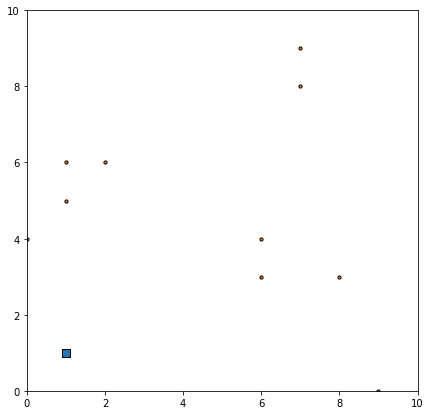

In [110]:
fig, ax = plt.subplots(figsize=(7,7))
scatter = ax.scatter(all_positions.iloc[0][0][:,0], all_positions.iloc[0][0][:,1], 
                  s=50, cmap="jet", edgecolor="k",  marker="s")
garbage = ax.scatter(all_positions.iloc[0][1][:,0], all_positions.iloc[0][1][:,1], 
                  s=10, cmap="jet", edgecolor="k")
ax.axis([0, ANCHO, 0, ALTO])
def update(frame_number):
    scatter.set_offsets(all_positions.iloc[frame_number][0])
    garbage.set_offsets(all_positions.iloc[frame_number][1])
    return scatter

anim = animation.FuncAnimation(fig, update, frames=MAX_ITERATIONS)

### Animación

In [ ]:
anim